In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import gc
pd.set_option('display.max_columns', None)

In [2]:
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for plotting
import matplotlib.pyplot as plt
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder,Normalizer,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## for explainer
#from lime import lime_tabular

In [3]:
#CFS implementation
#Source: https://github.com/ZixiaoShen/Correlation-based-Feature-Selection

import scipy.spatial as ss
from scipy.special import digamma
from math import log
import numpy.random as nr
import numpy as np
import random


# continuous estimators

def entropy(x, k=3, base=2):
    """
    The classic K-L k-nearest neighbor continuous entropy estimator x should be a list of vectors,
    e.g. x = [[1.3],[3.7],[5.1],[2.4]] if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    d = len(x[0])
    N = len(x)
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    tree = ss.cKDTree(x)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    const = digamma(N)-digamma(k) + d*log(2)
    return (const + d*np.mean(map(log, nn)))/log(base)


def mi(x, y, k=3, base=2):
    """
    Mutual information of x and y; x, y should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    points = zip2(x, y)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(x, dvec), avgdigamma(y, dvec), digamma(k), digamma(len(x))
    return (-a-b+c+d)/log(base)


def cmi(x, y, z, k=3, base=2):
    """
    Mutual information of x and y, conditioned on z; x, y, z should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    z = [list(p + intens * nr.rand(len(z[0]))) for p in z]
    points = zip2(x, y, z)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(zip2(x, z), dvec), avgdigamma(zip2(y, z), dvec), avgdigamma(z, dvec), digamma(k)
    return (-a-b+c+d)/log(base)


def kldiv(x, xp, k=3, base=2):
    """
    KL Divergence between p and q for x~p(x), xp~q(x); x, xp should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    assert k <= len(xp) - 1, "Set k smaller than num. samples - 1"
    assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    d = len(x[0])
    n = len(x)
    m = len(xp)
    const = log(m) - log(n-1)
    tree = ss.cKDTree(x)
    treep = ss.cKDTree(xp)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    nnp = [treep.query(point, k, p=float('inf'))[0][k-1] for point in x]
    return (const + d*np.mean(map(log, nnp))-d*np.mean(map(log, nn)))/log(base)


# Discrete estimators
def entropyd(sx, base=2):
    """
    Discrete entropy estimator given a list of samples which can be any hashable object
    """

    return entropyfromprobs(hist(sx), base=base)


def midd(x, y):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return -entropyd(list(zip(x, y)))+entropyd(x)+entropyd(y)


def cmidd(x, y, z):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return entropyd(list(zip(y, z)))+entropyd(list(zip(x, z)))-entropyd(list(zip(x, y, z)))-entropyd(z)


def hist(sx):
    # Histogram from list of samples
    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return map(lambda z: float(z)/len(sx), d.values())


def entropyfromprobs(probs, base=2):
    # Turn a normalized list of probabilities of discrete outcomes into entropy (base 2)
    return -sum(map(elog, probs))/log(base)


def elog(x):
    # for entropy, 0 log 0 = 0. but we get an error for putting log 0
    if x <= 0. or x >= 1.:
        return 0
    else:
        return x*log(x)


# Mixed estimators
def micd(x, y, k=3, base=2, warning=True):
    """ If x is continuous and y is discrete, compute mutual information
    """

    overallentropy = entropy(x, k, base)
    n = len(y)
    word_dict = dict()
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1./n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        if k <= len(xgiveny) - 1:
            mi -= word_dict[yval]*entropy(xgiveny, k, base)
        else:
            if warning:
                print("Warning, after conditioning, on y={0} insufficient data. Assuming maximal entropy in this case.".format(yval))
            mi -= word_dict[yval]*overallentropy
    return mi  # units already applied


# Utility functions
def vectorize(scalarlist):
    """
    Turn a list of scalars into a list of one-d vectors
    """

    return [(x,) for x in scalarlist]


def shuffle_test(measure, x, y, z=False, ns=200, ci=0.95, **kwargs):
    """
    Shuffle test
    Repeatedly shuffle the x-values and then estimate measure(x,y,[z]).
    Returns the mean and conf. interval ('ci=0.95' default) over 'ns' runs, 'measure' could me mi,cmi,
    e.g. Keyword arguments can be passed. Mutual information and CMI should have a mean near zero.
    """

    xp = x[:]   # A copy that we can shuffle
    outputs = []
    for i in range(ns):
        random.shuffle(xp)
        if z:
            outputs.append(measure(xp, y, z, **kwargs))
        else:
            outputs.append(measure(xp, y, **kwargs))
    outputs.sort()
    return np.mean(outputs), (outputs[int((1.-ci)/2*ns)], outputs[int((1.+ci)/2*ns)])


# Internal functions
def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    for i in range(N):
        dist = dvec[i]
        # subtlety, we don't include the boundary point,
        # but we are implicitly adding 1 to kraskov def bc center point is included
        num_points = len(tree.query_ball_point(points[i], dist-1e-15, p=float('inf')))
        avg += digamma(num_points)/N
    return avg


def zip2(*args):
    # zip2(x,y) takes the lists of vectors and makes it a list of vectors in a joint space
    # E.g. zip2([[1],[2],[3]],[[4],[5],[6]]) = [[1,4],[2,5],[3,6]]
    return [sum(sublist, []) for sublist in zip(*args)]

In [4]:
def information_gain(f1, f2):
    """
    This function calculates the information gain, where ig(f1,f2) = H(f1) - H(f1|f2)
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    ig: {float}
    """

    ig = entropyd(f1) - conditional_entropy(f1, f2)
    return ig


def conditional_entropy(f1, f2):
    """
    This function calculates the conditional entropy, where ce = H(f1) - I(f1;f2)
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    ce: {float}
        ce is conditional entropy of f1 and f2
    """

    ce = entropyd(f1) - midd(f1, f2)
    return ce


def su_calculation(f1, f2):
    """
    This function calculates the symmetrical uncertainty, where su(f1,f2) = 2*IG(f1,f2)/(H(f1)+H(f2))
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    su: {float}
        su is the symmetrical uncertainty of f1 and f2
    """

    # calculate information gain of f1 and f2, t1 = ig(f1,f2)
    t1 = information_gain(f1, f2)
    # calculate entropy of f1, t2 = H(f1)
    t2 = entropyd(f1)
    # calculate entropy of f2, t3 = H(f2)
    t3 = entropyd(f2)
    # su(f1,f2) = 2*t1/(t2+t3)
    su = 2.0*t1/(t2+t3)

    return su

In [5]:
def merit_calculation(X, y):
    """
    This function calculates the merit of X given class labels y, where
    merits = (k * rcf)/sqrt(k+k*(k-1)*rff)
    rcf = (1/k)*sum(su(fi,y)) for all fi in X
    rff = (1/(k*(k-1)))*sum(su(fi,fj)) for all fi and fj in X
    Input
    ----------
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ----------
    merits: {float}
        merit of a feature subset X
    """

    n_samples, n_features = X.shape
    rff = 0
    rcf = 0
    for i in range(n_features):
        fi = X[:, i]
        rcf += su_calculation(fi, y)
        for j in range(n_features):
            if j > i:
                fj = X[:, j]
                rff += su_calculation(fi, fj)
    rff *= 2
    merits = rcf / np.sqrt(n_features + rff)
    return merits


def cfs(X, y):
    """
    This function uses a correlation based heuristic to evaluate the worth of features which is called CFS
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    F: {numpy array}
        index of selected features
    Reference
    ---------
    Zhao, Zheng et al. "Advancing Feature Selection Research - ASU Feature Selection Repository" 2010.
    """

    n_samples, n_features = X.shape
    F = []
    # M stores the merit values
    M = []
    while True:
        merit = -100000000000
        idx = -1
        for i in range(n_features):
            if i not in F:
                F.append(i)
                # calculate the merit of current selected features
                t = merit_calculation(X[:, F], y)
                if t > merit:
                    merit = t
                    idx = i
                F.pop()
        F.append(idx)
        M.append(merit)
        if len(M) > 5:
            if M[len(M)-1] <= M[len(M)-2]:
                if M[len(M)-2] <= M[len(M)-3]:
                    if M[len(M)-3] <= M[len(M)-4]:
                        if M[len(M)-4] <= M[len(M)-5]:
                            break
    return np.array(F)

In [7]:
#a = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
#b = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
a = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
b = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
c =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
d =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
e =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#c = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week3.csv', low_memory=False , encoding='cp1252')
#d = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week4.csv', low_memory=False, encoding='cp1252')
#e =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
#g =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
#h =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')

In [8]:
print(b.shape)
#a.drop(a[a['attackType'] == '---'].index, axis = 0, inplace= True) 
b.drop(b[b['attackType'] == '---'].index, axis = 0, inplace= True)  
c.drop(c[c['attackType'] == '---'].index, axis = 0, inplace= True)  
d.drop(d[d['attackType'] == '---'].index, axis = 0, inplace= True)  
#e.drop(e[e['attackType'] == '---'].index, axis = 0, inplace= True)  
b.shape

(10310733, 16)


(1795404, 16)

In [9]:
data_external = pd.concat([c,d,e], axis = 0)
data_external.reset_index(drop= True, inplace= True)

In [10]:
#to Increment attackID values
data_external['attackID'] = data_external['attackID'].apply(lambda x: str(int(x) + 70) if x != '---' else x)

In [11]:
def convert_bytes(df):
    if 'M' in df:
        df = df.split('M')
        df = df[0].strip()
        df = float(df) * 1000000
    elif 'B' in df:
        df = df.split('B')
        df = df[0].strip()
        df =  float(df) * 1000000000
    else: 
        df =float(df)
    return df

In [12]:
data = pd.concat([a,b,data_external], axis = 0)
data.reset_index(drop= True, inplace= True)
data['Bytes'] = data['Bytes'].apply(lambda x: convert_bytes(x))
data['attackType'] = data['attackType'].apply(lambda x:  'attack' if (x!= '---') else x )
columns = ['Src Pt', 'Dst Pt','Tos','Flows','Packets', 'Bytes']
for i in columns:
    data[i] = pd.to_numeric(data[i]);
del columns
del a,b,c,d,e, data_external
gc.collect()

60

In [13]:
#Converts Hexadecimal value to Binary
def hex_to_binary(hexdata):
    scale = 16 ## equals to hexadecimal
    num_of_bits = 9
    return bin(int(hexdata, scale))[2:].zfill(num_of_bits);
#Converts TCP flags to Binary
def to_Binary(x):
    l = 0
    x = '...' + x
    x = list(x)
    for i in x:
        if (i=='.'):
            x[l]= '0'
        else:
            x[l] = '1'
        l = l +1
    return ''.join(x)
#Converts the 'Flags' column to 9 indiviual columns (manual oneshot encoding)
def flag_convert(df):  
   # df['Flags'] = df['Flags'].apply(lambda x: (list(x)))
   # temp = df['Flags'].apply(lambda x: toBinary(x))
    hex_values = list(df[(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    flag_values = list(df[~(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    binary_values = {}
    for i in hex_values:
         binary_values[i] = (hex_to_binary(i))
    for i in flag_values:
         binary_values[i] = (to_Binary(i))
    temp = df['Flags'].replace(binary_values)
#temp = temp.apply(lambda x: pd.Series(x)) 
    temp = pd.DataFrame(temp.apply(list).tolist())
#temp = pd.DataFrame(temp)
#a = a.iloc[: , 1:]
   # print(temp.head())
    temp.columns = ['N','C','E','U' ,'A','P','R','S','F']
    for i in temp.columns:
        temp[i] = pd.to_numeric(temp[i]);
    temp = temp.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp], axis = 1)
    return df;

In [14]:
#make a IP_pairs 
def make_pair(df):
    ip_pair = df['Src IP Addr'] +'/' +df['Dst IP Addr']
    source_ip = df['Src IP Addr'].unique().tolist()
    destination_ip = df['Dst IP Addr'].unique().tolist()
   # df = df.drop(columns = ['Src IP Addr', 'Dst IP Addr'])
    df.insert(1, ' IP Pair', ip_pair)
    return df

def check_inverse(df):
    list_pairs = df[' IP Pair'].unique()
    tuple_pair = []
    for i in list_pairs:
        tuple_pair.append(tuple((i.split('/'))))
    dic_store = {}
    for i in tuple_pair:
        if (i  not in dic_store.keys()) and (i[::-1] not in dic_store.keys()):
            dic_store[i] = i[0] + '/' +i[1]
    print(len(dic_store.keys()))
    dic_final = {}
    for i in dic_store.keys():
        dic_final[i[0] + '/' +i[1]] = dic_store[i]
        dic_final[i[1] + '/' +i[0]] = dic_store[i]
    df[' IP Pair'] = df[' IP Pair'].map(dic_final)               
    return df

In [15]:
def normalize_IP(df):
    columns = ['sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3', 'sourceIP_feature 4', 'destIP_feature 1',
              'destIP_feature 2', 'destIP_feature 3', 'destIP_feature 4']
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [16]:
def normalize(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    columns = data.select_dtypes(include=numerics).columns
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [17]:
def one_shot(df):
    label_encoder = LabelEncoder()
    #df.astype({'attackType': 'str'})
    df['attackType'] = label_encoder.fit_transform(df['attackType'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    
    df['sourceIP_feature 1'] = label_encoder.fit_transform(df['sourceIP_feature 1'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['sourceIP_feature 2'] = label_encoder.fit_transform(df['sourceIP_feature 2'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['sourceIP_feature 3'] = label_encoder.fit_transform(df['sourceIP_feature 3'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['sourceIP_feature 4'] = label_encoder.fit_transform(df['sourceIP_feature 4'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 1'] = label_encoder.fit_transform(df['destIP_feature 1'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 2'] = label_encoder.fit_transform(df['destIP_feature 2'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 3'] = label_encoder.fit_transform(df['destIP_feature 3'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 4'] = label_encoder.fit_transform(df['destIP_feature 4'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['Proto'] = label_encoder.fit_transform(df['Proto'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    onehot_encoder1 = OneHotEncoder()
    onehot_encoder1.fit(df.Proto.to_numpy().reshape(-1, 1))
    proto = onehot_encoder1.transform(df.Proto.to_numpy().reshape(-1, 1))
    proto = pd.DataFrame.sparse.from_spmatrix(proto)
    proto.astype('int32')
    proto.columns = label_encoder.classes_
   # print(proto.head(1))
    df = pd.concat([df, proto], axis = 1)
    return df;

In [18]:
def drop_columns(df):
    return df.drop(columns = ['Date first seen', ' IP Pair', 'Flows', 'class', 'attackID','Flags',
                              'attackDescription', 'Src IP Addr', 'Dst IP Addr','Proto'], axis =1)

In [19]:
#Aplit IP address into features, 7 features
def split_to_net(IP_address):
    IP_list = IP_address.split(".")
    needed_len = 7
    needed_len = needed_len - len(IP_list)
    for i in range(0,needed_len,1):
        IP_list.append('0')
    return IP_list
#replace unknown IP address, and convert to columns
def IP_split(df): 
    replace = {"ATTACKER1":"0.0.0.0",
           "ATTACKER2":"0.0.0.0",
           "ATTACKER3":"0.0.0.0",
           "EXT_SERVER": "0.0.0.0.1",
          "OPENSTACK_NET": "0.0.0.0.0.1",
          "DNS": "0.0.0.0.0.0.1"}
    df = df.replace({"Src IP Addr": replace, "Dst IP Addr": replace}, value=None)
    temp_source = df["Src IP Addr"].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
    temp_des = df['Dst IP Addr'].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
   # sourceIP = list(df["Src IP Addr"].unique())
   # destIP = list(df["Dst IP Addr"].unique())
   # sourceIP_values = {}
   # desIP_values = {}
   # for i in sourceIP:
   #      sourceIP_values[i] = (split_to_net(i))
   # for i in destIP:
   #      desIP_values[i] = (split_to_net(i))
    #print(sourceIP_values)
   # print(desIP_values)
#for Source IP
    temp_source = temp_source.apply(lambda x: split_to_net(x) )
    temp_source = pd.DataFrame(temp_source.apply(list).tolist())
    temp_source.columns = ['sourceIP_feature 1','sourceIP_feature 2','sourceIP_feature 3','sourceIP_feature 4' ,
                    'sourceEXT_SERVER','sourceOPENSTACK_NET','sourceDNS']
    for i in temp_source.columns:
        temp_source[i] = pd.to_numeric(temp_source[i]);
    temp_source = temp_source.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_source], axis = 1)
    #for Destination IP
    temp_des = temp_des.apply(lambda x: split_to_net(x) )
    temp_des = pd.DataFrame(temp_des.apply(list).tolist())
    temp_des.columns = ['destIP_feature 1','destIP_feature 2','destIP_feature 3','destIP_feature 4' ,
                    'destEXT_SERVER','destOPENSTACK_NET','destDNS']
    for i in temp_des.columns:
        temp_des[i] = pd.to_numeric(temp_des[i]);
    temp_des = temp_des.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_des], axis = 1)
    return df;

In [20]:
data = make_pair(data)
data = check_inverse(data)

59362


In [21]:
data = IP_split(data)

In [22]:
data = normalize(data)
data =  one_shot(data) 
data = normalize_IP(data)

Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos',
       'sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3',
       'sourceIP_feature 4', 'sourceEXT_SERVER', 'sourceOPENSTACK_NET',
       'sourceDNS', 'destIP_feature 1', 'destIP_feature 2', 'destIP_feature 3',
       'destIP_feature 4', 'destEXT_SERVER', 'destOPENSTACK_NET', 'destDNS'],
      dtype='object')
['---', 'attack']
[0, 1]
[0.0, 1.0]
[0, 1]
[0.0, 1.0]
[0, 1]
[0.0, 0.003952569169960474, 0.01976284584980237, 0.3162055335968379, 0.3952569169960474, 0.7905138339920948, 0.8300395256916996, 0.8695652173913043, 0.9999999999999999]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036000000000000004, 0.04, 0.044, 0.048, 0.052000000000000005, 0.056, 0.06, 0.064, 0.4, 0.432, 0.456, 0.612, 0.884, 0.96, 1.0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0.0, 0.7529411764705882, 1.0]
[0, 1, 2]
[0.0, 0.6588235294117647,

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


['sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3', 'sourceIP_feature 4', 'destIP_feature 1', 'destIP_feature 2', 'destIP_feature 3', 'destIP_feature 4']


In [22]:
#data = flag_convert(data)
#data_cfs = drop_columns(data)

In [28]:
#cfs_Y = data_cfs['attackType'].to_numpy()
#cfs_X = data_cfs.drop(['attackType'], axis = 1).to_numpy()

In [29]:
#cfs_index = cfs(cfs_X, cfs_Y)

In [30]:
#After running CFS feature selection algorithm.
cfs_index = [33, 32,  9, 16,  0,  6,  3]

array([33, 32,  9, 16,  0,  6,  3])

In [52]:
#selected_features = data_cfs.drop(['attackType'], axis = 1)
#selected_features = selected_features.iloc[:, cfs_index]
#selected_features = pd.concat([selected_features,data['attackType'] ], axis = 0)

In [53]:
#selected_features.head()

,F,S,sourceIP_feature 4,destIP_feature 4,Duration,sourceIP_feature 1,Packets
0,0,0,0.217391,0.062745,0.000000e+00,1.0,0.000000
1,0,0,0.217391,0.058824,0.000000e+00,1.0,0.000000
2,0,0,0.652174,0.019608,6.613570e-09,1.0,0.000005
3,0,0,0.695652,0.019608,6.613570e-09,1.0,0.000005
4,0,0,0.217391,0.058824,0.000000e+00,1.0,0.000000


In [23]:
gc.collect()

20

In [24]:
from datetime import datetime
def unix_time(df):
  #  df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x + ':00' if len(x) != 19 else x)
   # df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x[0 : 5 : ] + x[7 : :] if len(x) != 19 else x[0 : 7 : ] + x[9 : :])
    df['Date first seen'] = df['Date first seen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
    df['Date first seen'] = df['Date first seen'].apply(lambda x: x.timestamp()*1000)
    return df;

In [25]:
def normal_profile(grouped):
    grouped['---'] = unix_time(grouped['---'])
    start_time = int(grouped['---'].head(1)['Date first seen'].values[0])
    end_time = int(grouped['---'].tail(1)['Date first seen'].values[0])
#date_bins = pd.IntervalIndex.from_tuples(
#        [(i, i+3600000) for i in range(start_time, end_time, 3600000)],
#        closed="left")
#date_labels = [f"{i}" for i in range(1, len(date_bins)+1, 1)]
    normal_data = dict(tuple( grouped['---'].groupby( pd.cut(
            grouped['---']['Date first seen'],
               np.arange(start_time, end_time, 3*3600000)))))
    del grouped['---']
    num = []
    for i in grouped_data.keys():
          num.append(len(grouped_data[i]))
    print(min(num))
    num = max(num)
    print(num)
    print(len(grouped.keys()))
    grouped = {**grouped, **normal_data}
    print(len(grouped.keys()))
    return grouped, num;

In [26]:
grouped_data= dict(tuple(data.groupby(['attackID'])))
del data
gc.collect()

0

In [27]:
no_1 = []
no_2 = []
no_3 = []
no_4 = []
for i in grouped_data.keys():
   
    if grouped_data[i]['attackType'].unique()[0] == 0:
        print(f"{i}: {len(grouped_data[i])} : {grouped_data[i]['attackType'].unique()[0]}")
    if grouped_data[i]['attackType'].unique()[0] == 1:
              no_1.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 2:
              no_2.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 3:
              no_3.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 4:
              no_4.append(i)
for i in no_1:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"dos : {len(no_2)}")
for i in no_2:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"pingScan: {len(no_3)}")
for i in no_3:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"portScan : {len(no_4)}")
for i in no_4:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")


---: 7195669 : 0
Attack ID: 1; Lenght of Attack: 7657; Attack Type: 1
Attack ID: 10; Lenght of Attack: 311; Attack Type: 1
Attack ID: 11; Lenght of Attack: 17401; Attack Type: 1
Attack ID: 12; Lenght of Attack: 11526; Attack Type: 1
Attack ID: 13; Lenght of Attack: 513; Attack Type: 1
Attack ID: 14; Lenght of Attack: 13807; Attack Type: 1
Attack ID: 15; Lenght of Attack: 64; Attack Type: 1
Attack ID: 16; Lenght of Attack: 261003; Attack Type: 1
Attack ID: 17; Lenght of Attack: 13338; Attack Type: 1
Attack ID: 18; Lenght of Attack: 295302; Attack Type: 1
Attack ID: 19; Lenght of Attack: 11672; Attack Type: 1
Attack ID: 2; Lenght of Attack: 1927; Attack Type: 1
Attack ID: 20; Lenght of Attack: 11748; Attack Type: 1
Attack ID: 21; Lenght of Attack: 5113; Attack Type: 1
Attack ID: 22; Lenght of Attack: 295; Attack Type: 1
Attack ID: 23; Lenght of Attack: 72788; Attack Type: 1
Attack ID: 24; Lenght of Attack: 466; Attack Type: 1
Attack ID: 25; Lenght of Attack: 201; Attack Type: 1
Attack ID

In [28]:
del no_1
del no_2
del no_3
del no_4
gc.collect()

20

In [29]:
def del_largeInstances(dic, length):
    remove_ID = []
    for i in dic.keys():
        if (i != '---'):
            if(len(dic[i]) >= length):
                remove_ID.append(i)
    print(len(remove_ID))
    removed_attacks = {}
    for i in remove_ID:
        removed_attacks[i] = dic[i]
        del dic[i]
    return dic;

In [30]:
grouped_data = del_largeInstances(grouped_data, 20000)

19


In [31]:
#grouped_data, num = normal_profile(grouped_data)
grouped_data1= {}
for i in grouped_data.keys():
    grouped_data[i] = flag_convert(grouped_data[i])
   # grouped_data[i] =  drop_columns(grouped_data[i])
grouped_data, num = normal_profile(grouped_data)
for i in grouped_data.keys():
   # grouped_data[i] = flag_convert(grouped_data[i])
    grouped_data[i] =  drop_columns(grouped_data[i])

40
19732
73
350


In [32]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1492095676632, 1492106476632] : False
(1492106476632, 1492117276632] : False
(1492117276632, 1492128076632] : False
(1492128076632, 1492138876632] : False
(1492138876632, 1492149676632] : False
(1492149676632, 1492160476632] : False
(1492160476632, 1492171276632] : False
(1492171276632, 1492182076632] : False
(1492182076632, 1492192876632] : False
(1492192876632, 1492203676632] : False
(1492203676632, 1492214476632] : False
(1492214476632, 1492225276632] : False
(1492225276632, 1492236076632] : False
(1492236076632, 1492246876632] : False
(1492246876632, 1492257676632] : False
(1492257676632, 1492268476632] : False
(1492268476632, 1492279276632] : False
(1492279276632, 1492290076632] : False
(1492290076632, 1492300876632] : False
(1492300876632, 1492311676632] : False
(1492311676632, 1492322476632] : False
(1492322476632, 1492333276632] : False
(1492333276632, 1492344076632] : False
(1492344076632, 1492354876632] : False
(1492354876632, 1492365676632] : False
(1492365676632, 149237647

In [33]:
counter = 0
for i in grouped_data.keys():
    if ( len(grouped_data[i]) == 0):
        counter = counter +1;
print(f"Number of Instances which are empty: {counter}")

Number of Instances which are empty: 167


In [34]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
#Convert to 3D arrays, input dict
def make_array(dic):
    x = []
    y = []
    zero_arrays = []
    for i in dic.keys():
        if ( len(dic[i]) == 0):
            zero_arrays.append(i);
    for i in zero_arrays:
        del dic[i]
    for i in dic.keys():
        x.append(np.array(dic[i].drop(['attackType'],axis = 1)).astype(np.float32))
       # print(f'{i}')
        y.append(dic[i]['attackType'].values[0])
    print(len(y))
    o = []
    features = len(x[1][1])
    #for i in x:
     #   o.append(len(i))
   # print(min(o))
    o = num
    o = roundup(o)
    print(o)
    index = 0
    for i in x:
        l = len(i)
        i = list(i)
        if(o > l):
            l = o-l
            for j in range(0, l, 1):
                i.append([0] * features)
        elif (o<l):
            l = l-o
            i = i[:-l]
        #i = [k = np.array([k]) for l in i for k in l] # Makes array elements an array 
        x[index] = np.array(i).astype(np.float32)
        index = index + 1
    #x = [[i] for i in x]
    return x,y

In [35]:
#Remove columns that were not listed in cfs list
cfs_rows = ['F','S','sourceIP_feature 4','destIP_feature 4','Duration','sourceIP_feature 1','Packets', 'attackType']
for i in grouped_data.keys():
    if ( len(grouped_data[i]) != 0):
        grouped_data[i] = grouped_data[i][cfs_rows]

In [36]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1492398076632, 1492408876632] : False
(1492408876632, 1492419676632] : False
(1492419676632, 1492430476632] : False
(1492430476632, 1492441276632] : False
(1492441276632, 1492452076632] : False
(1492452076632, 1492462876632] : False
(1492462876632, 1492473676632] : False
(1492473676632, 1492484476632] : False
(1492484476632, 1492495276632] : False
(1492495276632, 1492506076632] : False
(1492506076632, 1492516876632] : False
(1492516876632, 1492527676632] : False


In [37]:
X,Y = make_array(grouped_data)
del grouped_data
gc.collect()
Y = np.array(Y)
X = np.array(X)

183
19800


In [38]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 110, 1: 73}

In [39]:
def make_4D(arr):
    x = []
    for i in range(0, len(arr),1):
        temp = []
        for j in range(0,len(arr[i]),1):
             temp.append([np.array([k]) for k in arr[i][j]])
        x.append(np.array(temp).astype(np.float32))
    return np.array(x).astype(np.float32)

In [40]:
#X = make_4D(X)

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.2, random_state=0,  stratify=Y)

In [42]:
del X,Y
gc.collect()

100

In [43]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0: 88, 1: 58}

In [44]:
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

{0: 22, 1: 15}

In [45]:
for i in X_train:
    print(f'{np.isnan(i).any()}')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [46]:
nsamples,nx, ny = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny} \n " )

samples: 146 
 X:19800 
 Y:7 
 


In [47]:
X_train = X_train.reshape((nsamples,nx*ny))
X_test = X_test.reshape((37,nx*ny))

In [114]:
search_space = {
    "criterion": ("gini", "entropy"),
    "max_leaf_nodes": (2, 10, None),
    "max_depth": (1, nx*ny),
    "min_samples_split": (2, int(nsamples/4)),
    "min_samples_leaf": (1,int(nsamples/4) ),
    "min_weight_fraction_leaf": (0.01, 0.5),
    "max_features": ("auto", "sqrt","log2", None),
    "random_state": (0,42)
}

In [49]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta
cv = StratifiedKFold(n_splits=7, shuffle=True)

In [115]:
estimator = DecisionTreeClassifier()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

In [51]:
def print_status(optimal_result):
    """Shows the best parameters found and accuracy attained of the search so far."""
    models_tested = pd.DataFrame(bayes_cv_tuner.cv_results_)
    best_parameters_so_far = pd.Series(bayes_cv_tuner.best_params_)
    print(
        "Model #{}\nBest accuracy so far: {}\nBest parameters so far: {}\n".format(
            len(models_tested),
            np.round(bayes_cv_tuner.best_score_, 3),
            bayes_cv_tuner.best_params_,
        )
    )

In [116]:
result_dtc = bayes_cv_tuner.fit(X_train, Y_train, callback=[print_status, DeltaXStopper(0.0001)])

Model #1
Best accuracy so far: 0.603
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 83991), ('max_features', 'log2'), ('max_leaf_nodes', 10), ('min_samples_leaf', 10), ('min_samples_split', 15), ('min_weight_fraction_leaf', 0.4427807121610979), ('random_state', 31)])

Model #2
Best accuracy so far: 0.856
Best parameters so far: OrderedDict([('criterion', 'gini'), ('max_depth', 109786), ('max_features', 'sqrt'), ('max_leaf_nodes', None), ('min_samples_leaf', 16), ('min_samples_split', 23), ('min_weight_fraction_leaf', 0.12402682776978984), ('random_state', 26)])

Model #3
Best accuracy so far: 0.856
Best parameters so far: OrderedDict([('criterion', 'gini'), ('max_depth', 109786), ('max_features', 'sqrt'), ('max_leaf_nodes', None), ('min_samples_leaf', 16), ('min_samples_split', 23), ('min_weight_fraction_leaf', 0.12402682776978984), ('random_state', 26)])

Model #4
Best accuracy so far: 0.856
Best parameters so far: OrderedDict([('criterion', 'gini'), ('ma

Model #29
Best accuracy so far: 0.911
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 138600), ('max_features', 'auto'), ('max_leaf_nodes', None), ('min_samples_leaf', 1), ('min_samples_split', 36), ('min_weight_fraction_leaf', 0.01), ('random_state', 42)])

Model #30
Best accuracy so far: 0.911
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 138600), ('max_features', 'auto'), ('max_leaf_nodes', None), ('min_samples_leaf', 1), ('min_samples_split', 36), ('min_weight_fraction_leaf', 0.01), ('random_state', 42)])

Model #31
Best accuracy so far: 0.918
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 138600), ('max_features', 'sqrt'), ('max_leaf_nodes', None), ('min_samples_leaf', 1), ('min_samples_split', 25), ('min_weight_fraction_leaf', 0.01), ('random_state', 42)])

Model #32
Best accuracy so far: 0.918
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 138600), ('max_featur

In [117]:
model_dtc = DecisionTreeClassifier(
    criterion = result_dtc.best_params_['criterion'],
     max_leaf_nodes =  result_dtc.best_params_['max_leaf_nodes'],
       max_depth = result_dtc.best_params_['max_depth'],
    min_samples_split = result_dtc.best_params_['min_samples_split'],
    min_samples_leaf = result_dtc.best_params_['min_samples_leaf'],
    min_weight_fraction_leaf = result_dtc.best_params_['min_weight_fraction_leaf'],
    max_features = result_dtc.best_params_['max_features'],
    random_state = result_dtc.best_params_['random_state'],


    )

In [118]:
model_dtc.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=138600,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=36,
                       min_weight_fraction_leaf=0.01, presort=False,
                       random_state=0, splitter='best')

In [119]:
# predict probabilities for test set
yhat_probs = model_dtc.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [120]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [121]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.945946
Precision: 0.943939
Recall: 0.943939
F1 score: 0.943939


In [122]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.887879
[[21  1]
 [ 1 14]]


In [123]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


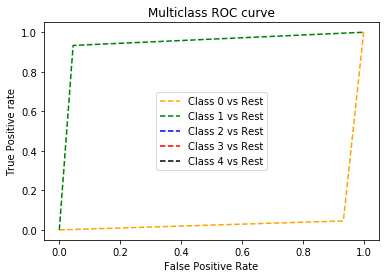

In [124]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [125]:
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[21  1]
 [ 1 14]]


In [126]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.93      0.93      0.93        15

    accuracy                           0.95        37
   macro avg       0.94      0.94      0.94        37
weighted avg       0.95      0.95      0.95        37



In [127]:
import pickle
filename = './models/CFS feature selection/With IP_ Top 7/Binary/DT/DT.sav'
pickle.dump(model_dtc, open(filename, 'wb'))
gc.collect()

5649

In [64]:
from skopt.space import Real, Categorical, Integer
search_space = {
    "C": Real(1e-6, 1e+6, prior='log-uniform'),
    "gamma": Real(1e-6, 1e+1, prior='log-uniform'),
    "kernel": Categorical(['linear', 'rbf']),
}

In [65]:
from sklearn import svm
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

scorers = {
 #   'precision_score': make_scorer(precision_score),
#    'recall_score': make_scorer(recall_score),
#    'accuracy_score': make_scorer(accuracy_score),
    'f1_score':make_scorer(f1_score)
}
estimator = svm.SVC()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

In [66]:
result_svm = bayes_cv_tuner.fit(X_train, Y_train, callback= [DeltaXStopper(0.0001), 
                                     print_status])


Model #1
Best accuracy so far: 0.89
Best parameters so far: OrderedDict([('C', 0.2161007595902223), ('gamma', 0.00018751314698429989), ('kernel', 'rbf')])

Model #2
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('C', 0.0019012508289686957), ('gamma', 0.02789122977352746), ('kernel', 'linear')])

Model #3
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('C', 0.0019012508289686957), ('gamma', 0.02789122977352746), ('kernel', 'linear')])

Model #4
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('C', 0.0019012508289686957), ('gamma', 0.02789122977352746), ('kernel', 'linear')])

Model #5
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('C', 0.0019012508289686957), ('gamma', 0.02789122977352746), ('kernel', 'linear')])

Model #6
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('C', 0.0019012508289686957), ('gamma', 0.02789122977352746), ('kernel', 'linear')])

Model #7
Best accuracy so far: 0.986
Best pa

In [67]:
#Create a svm Classifier
clf = svm.SVC(kernel= result_svm.best_params_['kernel'], C = result_svm.best_params_['C'], gamma = result_svm.best_params_['gamma'])

#Train the model using the training sets
clf.fit(X_train, Y_train)

SVC(C=0.0019012508289686957, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.02789122977352746,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [68]:
# predict probabilities for test set
yhat_probs = clf.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [69]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [70]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.972973
Precision: 0.978261
Recall: 0.966667
F1 score: 0.971648


In [71]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.943338
[[22  0]
 [ 1 14]]


In [72]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


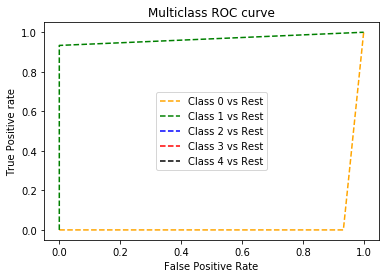

In [73]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [76]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 1 14]]


In [77]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.93      0.97        15

    accuracy                           0.97        37
   macro avg       0.98      0.97      0.97        37
weighted avg       0.97      0.97      0.97        37



In [78]:
import pickle
filename = './models/CFS feature selection/With IP_ Top 7/Binary/SVM/SVM.sav'
pickle.dump(clf, open(filename, 'wb'))
gc.collect()

3571

In [79]:
search_space = {
    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}

In [80]:
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

In [91]:
result_knn = bayes_cv_tuner.fit(X_train, Y_train, callback= [DeltaXStopper(0.0001), 
                                     print_status])


Model #1
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #2
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #3
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #4
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #5
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #6
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #7
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('wei

C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #19
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #20
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #21
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #22
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #23
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #24
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #25
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #26
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #27
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #28
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #29
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #30
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #31
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])

Model #32
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #33
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #34
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #35
Best accuracy so far: 0.795
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



In [92]:
model_KNN = KNeighborsClassifier(
    n_neighbors = result_knn.best_params_['n_neighbors'],
     weights =  result_knn.best_params_['weights'],
       metric = result_knn.best_params_['metric']
    )

In [93]:
model_KNN.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [94]:
# predict probabilities for test set
yhat_probs = model_KNN.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [95]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.837838
Precision: 0.840643
Recall: 0.853030
F1 score: 0.836765


In [96]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.677326
[[17  5]
 [ 1 14]]


In [97]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


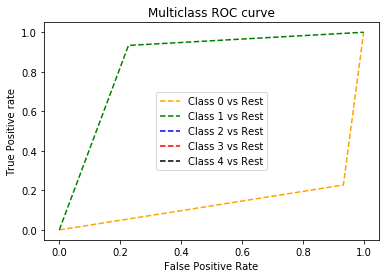

In [98]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [99]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[17  5]
 [ 1 14]]


In [100]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.77      0.85        22
           1       0.74      0.93      0.82        15

    accuracy                           0.84        37
   macro avg       0.84      0.85      0.84        37
weighted avg       0.86      0.84      0.84        37



In [101]:
import pickle
filename = './models/CFS feature selection/With IP_ Top 7/Binary/KNN/KNN.sav'
pickle.dump(model_KNN, open(filename, 'wb'))
gc.collect()

3703

In [102]:
from sklearn.ensemble import RandomForestClassifier
search_space = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
estimator = RandomForestClassifier()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

  

In [103]:
result_rf = bayes_cv_tuner.fit(X_train, Y_train, callback= [DeltaXStopper(0.0001), 
                                     print_status])


Model #1
Best accuracy so far: 0.979
Best parameters so far: OrderedDict([('max_depth', 23), ('min_samples_split', 6), ('n_estimators', 116)])

Model #2
Best accuracy so far: 0.979
Best parameters so far: OrderedDict([('max_depth', 23), ('min_samples_split', 6), ('n_estimators', 116)])

Model #3
Best accuracy so far: 0.979
Best parameters so far: OrderedDict([('max_depth', 23), ('min_samples_split', 6), ('n_estimators', 116)])

Model #4
Best accuracy so far: 0.979
Best parameters so far: OrderedDict([('max_depth', 23), ('min_samples_split', 6), ('n_estimators', 116)])

Model #5
Best accuracy so far: 0.979
Best parameters so far: OrderedDict([('max_depth', 23), ('min_samples_split', 6), ('n_estimators', 116)])

Model #6
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])

Model #7
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 

C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #25
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])

Model #26
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])

Model #27
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])

Model #28
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #29
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])

Model #30
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])

Model #31
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])

Model #32
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #33
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #34
Best accuracy so far: 0.986
Best parameters so far: OrderedDict([('max_depth', 25), ('min_samples_split', 8), ('n_estimators', 149)])



In [104]:
model_RF = RandomForestClassifier(
    n_estimators = result_rf.best_params_['n_estimators'],
     max_depth =  result_rf.best_params_['max_depth'],
       min_samples_split = result_rf.best_params_['min_samples_split']
    )

In [105]:
model_RF.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=149,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [106]:
# predict probabilities for test set
yhat_probs = model_RF.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [107]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [108]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [109]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


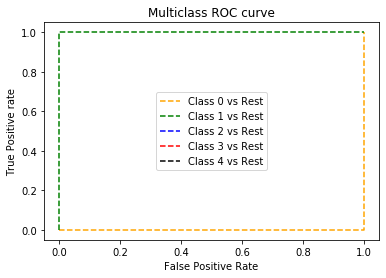

In [110]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [111]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [112]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [113]:
import pickle
filename = './models/CFS feature selection/With IP_ Top 7/Binary/RF/RF.sav'
pickle.dump(model_RF, open(filename, 'wb'))
gc.collect()

3802